# PROJECT OBJECTIVE: 
We will build a recommendation system using popularity based and collaborative filtering methods to recommend
mobile phones to a user which are most popular and personalised respectively.

#### CONTEXT: 
India is the second largest market globally for smartphones after China. About 134 million smartphones were sold across India
in the year 2017 and is estimated to increase to about 442 million in 2022. India ranked second in the average time spent on mobile web by
smartphone users across Asia Pacific. The combination of very high sales volumes and the average smartphone consumer behaviour has
made India a very attractive market for foreign vendors. As per Consumer behaviour, 97% of consumers turn to a search engine when they
are buying a product vs. 15% who turn to social media. If a seller succeeds to publish smartphones based on user’s behaviour/choice at the
right place, there are 90% chances that user will enquire for the same. This Case Study is targeted to build a recommendation system
based on individual consumer’s behaviour or choice.
#### DATA DESCRIPTION:
- author : name of the person who gave the rating
- country : country the person who gave the rating belongs to
- data : date of the rating
- domain: website from which the rating was taken from
- extract: rating content
- language: language in which the rating was given
- product: name of the product/mobile phone for which the rating was given
- score: average rating for the phone
- score_max: highest rating given for the phone
- source: source from where the rating was taken

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from surprise import SVD
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split


### 1. Read the provided CSVs as a data frame and prfeorm following actions
- Merge the provided CSVs into one data-frame.
- Check a few observations and shape of the data-frame.
- Round off scores to the nearest integers.
- Check for missing values. Impute the missing values if there is any.
- Check for duplicate values and remove them if there is any.
- Keep only 1000000 data samples. Use random state=612.
- Drop irrelevant features. Keep features like Author, Product, and Score.

In [2]:
#reading the data-

# while importing the data using rea.csv, we ran into an error as 
# --> "phone_user_review_file_1.csv" is not UTF-8 encoded.
# --> 'utf-8' codec can't decode byte 0xd1 in position 254: unexpected end of data

# to read such files which are of old nature and cannot be read by default UTF encoder, 
# we define encoder from our end to read the special characters:

data1 = pd.read_csv("phone_user_review_file_1.csv", encoding=('ISO-8859-1'),low_memory =False)

In [3]:
data1.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,05/02/17,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,05/04/17,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,05/02/17,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,05/11/17,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [4]:
# to see if all the data is read, we read the longest string to see if all characters are included or not.
data1['product'][2]

'Samsung Galaxy S8 (64GB) G950U 5.8" 4G LTE Unlocked (GSM + CDMA, US WARRANTY) (Orchid Gray)'

In [5]:
# loading rest of datasets
data2 = pd.read_csv("phone_user_review_file_2.csv",encoding=('ISO-8859-1'),low_memory =False)
data3 = pd.read_csv("phone_user_review_file_3.csv",encoding=('ISO-8859-1'),low_memory =False)
data4 = pd.read_csv("phone_user_review_file_4.csv",encoding=('ISO-8859-1'),low_memory =False)
data5 = pd.read_csv("phone_user_review_file_5.csv",encoding=('ISO-8859-1'),low_memory =False)
data6 = pd.read_csv("phone_user_review_file_6.csv",encoding=('ISO-8859-1'),low_memory =False)

In [6]:
data2.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/leagoo-lead-7/,4/15/2015,en,us,Amazon,amazon.com,2.0,10.0,"The telephone headset is of poor quality , not...",luis,Leagoo Lead7 5.0 Inch HD JDI LTPS Screen 3G Sm...
1,/cellphones/leagoo-lead-7/,5/23/2015,en,gb,Amazon,amazon.co.uk,10.0,10.0,This is my first smartphone so I have nothing ...,Mark Lavin,Leagoo Lead 7 Lead7 MTK6582 Quad core 1GB RAM ...
2,/cellphones/leagoo-lead-7/,4/27/2015,en,gb,Amazon,amazon.co.uk,8.0,10.0,Great phone. Battery life not great but seems ...,tracey,Leagoo Lead 7 Lead7 MTK6582 Quad core 1GB RAM ...
3,/cellphones/leagoo-lead-7/,4/22/2015,en,gb,Amazon,amazon.co.uk,10.0,10.0,Best 90 quid I've ever spent on a smart phone,Reuben Ingram,Leagoo Lead 7 Lead7 MTK6582 Quad core 1GB RAM ...
4,/cellphones/leagoo-lead-7/,4/18/2015,en,gb,Amazon,amazon.co.uk,10.0,10.0,I m happy with this phone.it s very good.thx team,viorel,Leagoo Lead 7 Lead7 MTK6582 Quad core 1GB RAM ...


In [7]:
data3.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s-iii-slim-sm-g3812/,11/7/2015,pt,br,Submarino,submarino.com.br,6.0,10.0,"recomendo, eu comprei um, a um ano, e agora co...",herlington tesch,Samsung Smartphone Samsung Galaxy S3 Slim G381...
1,/cellphones/samsung-galaxy-s-iii-slim-sm-g3812/,10/2/2015,pt,br,Submarino,submarino.com.br,10.0,10.0,Comprei um pouco desconfiada do site e do celu...,Luisa Silva Marieta,Samsung Smartphone Samsung Galaxy S3 Slim G381...
2,/cellphones/samsung-galaxy-s-iii-slim-sm-g3812/,9/2/2015,pt,br,Submarino,submarino.com.br,10.0,10.0,"Muito bom o produto, obvio que tem versÃµes me...",Cyrus,Samsung Smartphone Samsung Galaxy S3 Slim G381...
3,/cellphones/samsung-galaxy-s-iii-slim-sm-g3812/,9/2/2015,pt,br,Submarino,submarino.com.br,8.0,10.0,Unica ressalva fica para a camera que poderia ...,Marcela Santa Clara Brito,Samsung Smartphone Samsung Galaxy S3 Slim G381...
4,/cellphones/samsung-galaxy-s-iii-slim-sm-g3812/,9/1/2015,pt,br,Colombo,colombo.com.br,8.0,10.0,Rapidez e atenÃ§Ã£o na entrega. O aparelho Ã© ...,Claudine Maria Kuhn Walendorff,"Smartphone Samsung Galaxy S3 Slim, Dual Chip, ..."


In [8]:
data4.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-s7262-duos-galaxy-ace/,3/11/2015,en,us,Amazon,amazon.com,2.0,10.0,was not conpatable with my phone as stated. I ...,Frances DeSimone,Samsung Galaxy Star Pro DUOS S7262 Unlocked Ce...
1,/cellphones/samsung-s7262-duos-galaxy-ace/,17/11/2015,en,in,Zopper,zopper.com,10.0,10.0,Decent Functions and Easy to Operate Pros:- Th...,Expert Review,Samsung Galaxy Star Pro S7262 Black
2,/cellphones/samsung-s7262-duos-galaxy-ace/,29/10/2015,en,in,Amazon,amazon.in,4.0,10.0,Not Good Phone such price. Hang too much and v...,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black)
3,/cellphones/samsung-s7262-duos-galaxy-ace/,29/10/2015,en,in,Amazon,amazon.in,6.0,10.0,not bad for features,Amazon Customer,Samsung Galaxy Star Pro GT-S7262 (Midnight Black)
4,/cellphones/samsung-s7262-duos-galaxy-ace/,29/10/2015,en,in,Amazon,amazon.in,10.0,10.0,Excellent product,NHK,Samsung Galaxy Star Pro GT-S7262 (Midnight Black)


In [9]:
data5.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/karbonn-k1616/,7/13/2016,en,in,91 Mobiles,91mobiles.com,2.0,10.0,I bought 1 month before. currently speaker is ...,venkatesh,Karbonn K1616
1,/cellphones/karbonn-k1616/,7/13/2016,en,in,91 Mobiles,91mobiles.com,6.0,10.0,"I just bought one week back, I have Airtel con...",Venkat,Karbonn K1616
2,/cellphones/karbonn-k1616/,7/13/2016,en,in,91 Mobiles,91mobiles.com,4.0,10.0,one problem in this handset opera is not worki...,krrish,Karbonn K1616
3,/cellphones/karbonn-k1616/,4/25/2014,en,in,Naaptol,naaptol.com,10.0,10.0,here Karbonn comes up with an another excellen...,BRIJESH CHAUHAN,Karbonn K1616 - Black
4,/cellphones/karbonn-k1616/,4/23/2013,en,in,Naaptol,naaptol.com,10.0,10.0,"What a phone, all so on Naaptol my god 23% off...",Suraj CHAUHAN,Karbonn K1616 - Black


In [10]:
data6.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-instinct-sph-m800/,9/16/2011,en,us,Phone Arena,phonearena.com,8.0,10.0,I've had the phone for awhile and it's a prett...,ajabrams95,Samsung Instinct HD
1,/cellphones/samsung-instinct-sph-m800/,2/13/2014,en,us,Amazon,amazon.com,6.0,10.0,to be clear it is not the sellers fault that t...,Stephanie,Samsung SPH M800 Instinct
2,/cellphones/samsung-instinct-sph-m800/,12/30/2011,en,us,Phone Scoop,phonescoop.com,9.0,10.0,Well i love this phone. i have had ton of phon...,snickers,Instinct M800
3,/cellphones/samsung-instinct-sph-m800/,10/18/2008,en,us,HandCellPhone,handcellphone.com,4.0,10.0,I have had my Instinct for several months now ...,A4C,Samsung Instinct
4,/cellphones/samsung-instinct-sph-m800/,9/6/2008,en,us,Reviewed.com,reviewed.com,6.0,10.0,i have had this instinct phone for about two m...,betaBgood,Samsung Instinct


In [11]:
print('The shape of the sheet1 are: ', data1.shape)
print('The shape of the sheet2 are: ', data2.shape)
print('The shape of the sheet3 are: ', data3.shape)
print('The shape of the sheet4 are: ', data4.shape)
print('The shape of the sheet5 are: ', data5.shape)
print('The shape of the sheet6 are: ', data6.shape)

The shape of the sheet1 are:  (374910, 11)
The shape of the sheet2 are:  (114925, 11)
The shape of the sheet3 are:  (312961, 11)
The shape of the sheet4 are:  (98284, 11)
The shape of the sheet5 are:  (350216, 11)
The shape of the sheet6 are:  (163837, 11)


In [12]:
# we'll merge the datasets now, into 1 dataframe:

dataset = pd.concat([data1, data2, data3, data4, data5, data6], axis=0)

In [13]:
dataset.shape

(1415133, 11)

In [14]:
dataset.head()

,phone_url,date,lang,country,source,domain,score,score_max,extract,author,product
0,/cellphones/samsung-galaxy-s8/,05/02/17,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8
1,/cellphones/samsung-galaxy-s8/,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8
2,/cellphones/samsung-galaxy-s8/,05/04/17,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl..."
3,/cellphones/samsung-galaxy-s8/,05/02/17,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T)
4,/cellphones/samsung-galaxy-s8/,05/11/17,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8


In [15]:
# for safety, we create a backup of the dataset 
dataset_copy = dataset

In [16]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.00706,2.616121,0.2,7.2,9.2,10.0,10.0
score_max,1351644.0,10.00000,0.000000,10.0,10.0,10.0,10.0,10.0


In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1415133 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1415133 non-null  object 
 1   date       1415133 non-null  object 
 2   lang       1415133 non-null  object 
 3   country    1415133 non-null  object 
 4   source     1415133 non-null  object 
 5   domain     1415133 non-null  object 
 6   score      1351644 non-null  float64
 7   score_max  1351644 non-null  float64
 8   extract    1395772 non-null  object 
 9   author     1351931 non-null  object 
 10  product    1415132 non-null  object 
dtypes: float64(2), object(9)
memory usage: 129.6+ MB


In [18]:
dataset['score'].unique()

array([10. ,  6. ,  9.2,  4. ,  8. ,  2. ,  9.6,  7.2,  6.8,  9. ,  8.3,
        8.8,  8.4,  5.3,  7. ,  6.4,  7.6,  nan,  5.2,  3.2,  4.4,  2.8,
        5.6,  3.6,  4.8,  1. ,  5. ,  3. ,  2.4,  9.3,  8.5,  9.5,  6.5,
        5.5,  9.8,  8.2,  8.6,  7.8,  9.4,  6.6,  6.2,  7.5,  9.9,  2.7,
        8.7,  6.7,  3.3,  7.7,  7.3,  9.7,  6.3,  7.4,  5.7,  4.7,  4.3,
        5.8,  4.2,  4.5,  2.2,  5.4,  7.9,  3.5,  4.6,  3.7,  2.5,  3.4,
        7.1,  8.1,  1.2,  1.4,  3.8,  9.1,  2.6,  1.6,  1.7,  1.5,  1.8,
        2.3,  6.1,  5.9,  1.3,  0.2,  0.4,  8.9,  6.9,  0.6,  4.9])

In [19]:
dataset['score_max'].unique()

array([10., nan])

In [20]:
# we'll now roundoff the scores onto the nearest integer:
dataset['score'] = round(dataset['score'])

In [21]:
dataset['score'].unique()

array([10.,  6.,  9.,  4.,  8.,  2.,  7.,  5., nan,  3.,  1.,  0.])

In [22]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
score,1351644.0,8.008083,2.617634,0.0,7.0,9.0,10.0,10.0
score_max,1351644.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0


In [23]:
# are there any null entries in dataset?
dataset.isnull().sum()

phone_url        0
date             0
lang             0
country          0
source           0
domain           0
score        63489
score_max    63489
extract      19361
author       63202
product          1
dtype: int64

In [24]:
# only 4 columns have null values present in them.
#we'll impute the median values for the int cols.

dataset = dataset.fillna(dataset.median())


In [25]:
# we'll drop the dataset where the char values are missing:

dataset = dataset.dropna()

In [26]:
dataset.isnull().any()

phone_url    False
date         False
lang         False
country      False
source       False
domain       False
score        False
score_max    False
extract      False
author       False
product      False
dtype: bool

In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1336416 entries, 0 to 163836
Data columns (total 11 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   phone_url  1336416 non-null  object 
 1   date       1336416 non-null  object 
 2   lang       1336416 non-null  object 
 3   country    1336416 non-null  object 
 4   source     1336416 non-null  object 
 5   domain     1336416 non-null  object 
 6   score      1336416 non-null  float64
 7   score_max  1336416 non-null  float64
 8   extract    1336416 non-null  object 
 9   author     1336416 non-null  object 
 10  product    1336416 non-null  object 
dtypes: float64(2), object(9)
memory usage: 122.4+ MB


In [28]:
# now we'll be removing duplicates from the dataset:
dataset = dataset.drop_duplicates()

In [29]:
dataset.shape

(1331593, 11)

In [30]:
# we create a small backup of thisdataset for later user
dataset_copy2 = dataset.copy()

In [31]:
# we have to keep only 10,00,000 records for the analysis:
dataset = dataset.sample(n=1000000, random_state=612)

In [32]:
dataset.shape

(1000000, 11)

In [33]:
# we also hae to remove irrelevant features and keep only useful values:
dataset.drop(['phone_url','date','lang','country','source','domain',
            'score_max','extract'], axis = 1, inplace = True)

In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 8765 to 81602
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   score    1000000 non-null  float64
 1   author   1000000 non-null  object 
 2   product  1000000 non-null  object 
dtypes: float64(1), object(2)
memory usage: 30.5+ MB


In [35]:
# copy of dataset
dataset_copy3 = dataset.copy()

### 2. Answer the following questions
- Identify the most rated features.
- Identify the users with most number of reviews.
- Select the data with products having more than 50 ratings and users who have given more than 50 ratings. Report the shape of the final dataset.

In [36]:
dataset.head()

,score,author,product
8765,10.0,Kdotj15,Samsung Galaxy S7 edge 32GB (Sprint)
233365,10.0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...
145859,10.0,ron,×××¤×× ×¡××××¨× Huawei Mate S 32GB
302180,8.0,katha_maria93,Sony Ericsson W395 blush titanium Handy
304586,2.0,paul george,Apple iPhone 3G 8GB SIM-Free - Black


In [37]:
# 1 - identify the most rated feature:
dataset.groupby('product')['score'].mean().sort_values(ascending=False).head(10)

product
Nokia Lumia 920 (yellow)                                                                                                   10.0
Kit Me Out FR - Samsung Galaxy Ace S5830 & S5839i Android Housse / Coque / Ãtui de Protection en TPU Gel GivrÃ©...        10.0
Smartphone Samsung Galaxy Ace 4 Lite Duos Dual Chip Desbloqueado Android 4.4 Tela 4 4GB 3G Wi-Fi CÃ¢mera 3MP - Preto       10.0
Kit Me Out FR - Samsung Galaxy S3 Mini i8190 III Android Housse / Coque / Ãtui de Protection en Gel TPU Papillon...       10.0
Smartphone Samsung Galaxy Ace 4 Lite Duos 4GB G313ML                                                                       10.0
Kit Me Out FR - Samsung Galaxy S3 Mini i8190 III Android Housse / Coque / Ãtui de Protection en Gel TPU Cercles...        10.0
Kit Me Out FR - Samsung Galaxy S3 Mini i8190 III Android Housse / Coque / Ãtui de Protection en Gel TPU Bleu Fleurs...    10.0
Nokia X6 - 32GB - Black Smartphone                                                              

In [38]:
dataset[['score','product']][dataset['score'] == 10].head(10)

,score,product
8765,10.0,Samsung Galaxy S7 edge 32GB (Sprint)
233365,10.0,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...
145859,10.0,×××¤×× ×¡××××¨× Huawei Mate S 32GB
50113,10.0,Apple smartphone: iPhone 5s - Goud
28860,10.0,Samsung Galaxy S7 32GB (Verizon)
197969,10.0,Samsung Galaxy S4 16GB (T-Mobile)
291833,10.0,Samsung Galaxy Note 4 - Smartphone libre Andro...
305374,10.0,"Asus ZenFone 2 Smartphone 5 pollici, RAM 2 GB,..."
258390,10.0,Samsung M7600
135494,10.0,LG T300


In [39]:
# 2 - users with most reviews:
dataset.author.value_counts().head(10)

Amazon Customer    57801
Cliente Amazon     14656
e-bit               6260
Client d'Amazon     5715
Amazon Kunde        3563
Anonymous           1968
einer Kundin        1953
einem Kunden        1432
unknown             1283
Anonymous           1096
Name: author, dtype: int64

In [40]:
# product with highest reviews
dataset['product'].value_counts().head()

Lenovo Vibe K4 Note (White,16GB)     3913
Lenovo Vibe K4 Note (Black, 16GB)    3228
OnePlus 3 (Graphite, 64 GB)          3127
OnePlus 3 (Soft Gold, 64 GB)         2643
Huawei P8lite zwart / 16 GB          1994
Name: product, dtype: int64

In [41]:
# 3 - Select the data with products having more than 50 ratings and users who have given more than 50 ratings.
# Report the shape of the final dataset.

In [42]:
df1 = pd.DataFrame(columns=['author', 'a_count'])
df1['author']=dataset['author'].value_counts().index.tolist() 
df1['a_count'] = list(dataset['author'].value_counts() > 50)

In [43]:
# get names of indexes for which count column value is False
index_names = df1[ df1['a_count'] == False ].index 
# drop these row indexes from dataFrame 
df1.drop(index_names, inplace = True) 
df1.head()

,author,a_count
0,Amazon Customer,True
1,Cliente Amazon,True
2,e-bit,True
3,Client d'Amazon,True
4,Amazon Kunde,True


In [44]:
# extracting product that got more than 50 ratings
df2 = pd.DataFrame(columns=['product', 'p_count'])
df2['product']=dataset['product'].value_counts().index.tolist() 
df2['p_count'] = list(dataset['product'].value_counts() > 50)

In [45]:
# get names of indexes for which count column value is False
index_names = df2[ df2['p_count'] == False ].index 
# drop these row indexes from dataFrame 
df2.drop(index_names, inplace = True)
df2.head()

,product,p_count
0,"Lenovo Vibe K4 Note (White,16GB)",True
1,"Lenovo Vibe K4 Note (Black, 16GB)",True
2,"OnePlus 3 (Graphite, 64 GB)",True
3,"OnePlus 3 (Soft Gold, 64 GB)",True
4,Huawei P8lite zwart / 16 GB,True


In [46]:
# selecting data rows where product is having more than 50 ratings.  
df3 = dataset[dataset['product'].isin(df2['product'])] 
df3.head()

,score,author,product
8765,10.0,Kdotj15,Samsung Galaxy S7 edge 32GB (Sprint)
233365,10.0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...
28860,10.0,stephensca,Samsung Galaxy S7 32GB (Verizon)
183941,8.0,martinsa,Sony Xperia Z C6603
197969,10.0,MoneyMike,Samsung Galaxy S4 16GB (T-Mobile)


In [47]:
# selecting data rows from df3 where author has given more than 50 ratings.
# 2c. so that we get the data with products having more than 50 ratings and users who have given more than 50 ratings
df4 = df3[df3['author'].isin(df1['author'])]
df4.head()

,score,author,product
233365,10.0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...
47652,2.0,Amazon Customer,"Apple iPhone 5s (Silver, 16GB)"
28936,10.0,einem Kunden,"ZTE Blade A452 Smartphone, 12,7 cm (5 Zoll) Di..."
353663,8.0,Client d'Amazon,Aukru Chargeur de batterie adaptateur Pour Sam...
224123,8.0,Amazon Customer,"Motorola Moto G 3rd Generation (Black, 16GB)"


In [48]:
# shape of new dataset are:
df4.shape

(109237, 3)

### 3. Build a popularity based model and recommend top 5 mobile phones.

In [49]:
#Creating copy of the dataset
df = dataset

In [50]:
df.head()

,score,author,product
8765,10.0,Kdotj15,Samsung Galaxy S7 edge 32GB (Sprint)
233365,10.0,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...
145859,10.0,ron,×××¤×× ×¡××××¨× Huawei Mate S 32GB
302180,8.0,katha_maria93,Sony Ericsson W395 blush titanium Handy
304586,2.0,paul george,Apple iPhone 3G 8GB SIM-Free - Black


In [51]:
#to build Popularity model, we'll be calculating the mean score for a product by grouping it.
ratings_mean_count = pd.DataFrame(df.groupby('product')['score'].mean()) 

In [52]:
ratings_mean_count.head()

,score
product,
"'Smartphone Meizu Pro 5, 5,7 pouces avec Exynos 7420 Octa 8 Core Processeur. mÃ©moire RAM 4 Go et 64 Go mÃ©moire...",8.0
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0
"(7.62 cm (3 )Afficheur/Ã©cran, 2 MPixCamÃ©ra;blanc)-Smartphone",6.0
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.0


In [53]:
# now, calculating the number of ratings per product-
ratings_mean_count['rating_counts'] = pd.DataFrame(df.groupby('product')['score'].count())  

In [54]:
ratings_mean_count.head()

,score,rating_counts
product,,
"'Smartphone Meizu Pro 5, 5,7 pouces avec Exynos 7420 Octa 8 Core Processeur. mÃ©moire RAM 4 Go et 64 Go mÃ©moire...",8.0,1
"'Sony Xperia X (F5122) â White â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0,1
"'Sony Xperia X (F5122) â rosa â Dual Sim (Google Android 6.0.1, 5 Display, 2 x CORTEX A72 1.8 GHz + 4 x cortex-a53...",10.0,1
"(7.62 cm (3 )Afficheur/Ã©cran, 2 MPixCamÃ©ra;blanc)-Smartphone",6.0,1
"(CUBOT) GT88 5.5"" qHD 1.3GHz MTK6572 2-Core Android 4.2.2 3G Phone 8MP CAM 512MB RAM 4GB ROM",8.0,1


In [55]:
# Recommending the 5 mobile phones based in highest mean score and highest number of ratings the product got. 
ratings_mean_count.sort_values(by=['score','rating_counts'], ascending=[False,False]).head()

,score,rating_counts
product,,
Samsung Galaxy Note5,10.0,144
Motorola Smartphone Motorola Moto X Desbloqueado Preto Android 4.2.2 CÃ¢mera 10MP e Frontal 2MP MemÃ³ria Interna de 16GB GSM,10.0,140
Nokia Smartphone Nokia Lumia 520 Desbloqueado Oi Preto Windows Phone 8 CÃ¢mera 5MP 3G Wi-Fi MemÃ³ria Interna 8G GPS,10.0,135
Samsung Smartphone Dual Chip Samsung Galaxy SIII Duos Desbloqueado Claro Azul Android 4.1 3G/Wi-Fi CÃ¢mera 5MP,10.0,128
Motorola Smartphone Motorola Moto G Dual Chip Desbloqueado TIM Android 4.3 Tela 4.5 8GB 3G Wi-Fi CÃ¢mera 5MP - Preto,10.0,126


### 4. Build a collaborative filtering model using SVD

In [56]:
# TO build C.F.SVD model, we'll be arranging columns in the order of user id,item id and rating to be fed in the svd
columns_titles = ['author','product','score']
vs_rev = dataset_copy3.reindex(columns=columns_titles)

In [57]:
vs_rev.head()

,author,product,score
8765,Kdotj15,Samsung Galaxy S7 edge 32GB (Sprint),10.0
233365,Cliente Amazon,Asus ZE551ML-2A760WW Smartphone ZenFone 2 Delu...,10.0
145859,ron,×××¤×× ×¡××××¨× Huawei Mate S 32GB,10.0
302180,katha_maria93,Sony Ericsson W395 blush titanium Handy,8.0
304586,paul george,Apple iPhone 3G 8GB SIM-Free - Black,2.0


In [58]:
# we'll keep only 5000 data samples

vs_data = vs_rev.sample(n=5000, random_state=612)

In [59]:
#Now, we'll build a collaborative filtering model usingsvd
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(vs_data,reader = reader)

In [60]:
trainset = data.build_full_trainset()

In [62]:
trainset.ur

defaultdict(list,
            {0: [(0, 2.0),
              (3, 4.0),
              (0, 4.0),
              (16, 6.0),
              (26, 2.0),
              (40, 10.0),
              (3, 6.0),
              (48, 4.0),
              (54, 2.0),
              (72, 2.0),
              (98, 8.0),
              (109, 10.0),
              (120, 10.0),
              (132, 10.0),
              (134, 8.0),
              (159, 6.0),
              (163, 6.0),
              (177, 2.0),
              (3, 6.0),
              (205, 10.0),
              (205, 10.0),
              (287, 2.0),
              (292, 2.0),
              (306, 2.0),
              (178, 8.0),
              (159, 8.0),
              (326, 6.0),
              (341, 10.0),
              (349, 8.0),
              (362, 10.0),
              (363, 4.0),
              (382, 8.0),
              (395, 10.0),
              (163, 2.0),
              (421, 4.0),
              (444, 8.0),
              (26, 10.0),
              (109, 10.0)

In [63]:
#now, we'll be fixing the algo
algo = SVD()
algo.fit(trainset)

In [64]:
# then predicting ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

In [65]:
predictions = algo.test(testset)

In [68]:
predictions

[Prediction(uid='Amazon Customer', iid='Samsung Galaxy J7 Prime 16GB', r_ui=8.048, est=7.726937253970531, details={'was_impossible': False}),
 Prediction(uid='Amazon Customer', iid='Samsung Galaxy Mega 6.3 - Smartphone libre Android (pantalla 6.3", cÃ¡mara 8 Mp, 8 GB, Dual-Core 1.7 GHz, 1.5 GB RAM), blanco (importado)', r_ui=8.048, est=7.2593012929292176, details={'was_impossible': False}),
 Prediction(uid='Amazon Customer', iid='Samsung Galaxy S7 Smartphone, 12,9 cm (5,1 Zoll) Display, LTE (4G)', r_ui=8.048, est=7.958426450477831, details={'was_impossible': False}),
 Prediction(uid='Amazon Customer', iid='Nokia 5800', r_ui=8.048, est=7.253644359106577, details={'was_impossible': False}),
 Prediction(uid='Amazon Customer', iid='Sony Ericsson W890i', r_ui=8.048, est=6.881218577996284, details={'was_impossible': False}),
 Prediction(uid='Amazon Customer', iid='Samsung Wave S8500 Smartphone (Super Amoled Display, Touchscreen, bada-Betriebssystem) metallic-black', r_ui=8.048, est=6.6609869

Observation:
- Above, we have the predictions for the test users.
- We have successfully predicted the products and their ratings from the users.

In [70]:
# we'll define custom function now, which can take integer input to make predcition for that input.

def get_top_n(predictions, n=5):
    # First, we'll map the predictions with each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # now, we'll sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#### 8. Try and recommend top 5 products for test users.

In [71]:
top_n = get_top_n(predictions, n=5)

In [72]:
type(top_n )

collections.defaultdict

In [75]:
# below are the top 5 predicted items and their ratings for test users.
top_n.items()

dict_items([('Amazon Customer', [('Microsoft Nokia X3 Handy (Ovi, UKW Radio, 3,2 MP) blue silver', 8.895382904991882), ('Nokia 6700 classic', 8.870724333432493), ('Sony Xperia L C2104 Unlocked Phone--U.S. Warranty (Red)', 8.812568627571748), ('Nokia N85', 8.80977086884777), ('Sony Ericsson T700', 8.808325312247812)]), ('krisheed', [('OnePlus 3 (Graphite, 64 GB)', 9.436087896573468), ('Samsung Galaxy S7 edge 32GB (Verizon)', 9.084141163713733), ('Samsung Galaxy S7 edge 32GB (AT&T)', 9.038542683309831), ("Huawei P9 Lite Smartphone, LTE, Display 5.2'' FHD, Processore Octa-Core Kirin 650, 16 GB Memoria Interna, 3GB RAM, Fotocamera 13 MP, Single-SIM, Android 6.0 Marshmallow, Nero [Italia]", 9.020897469813436), ('LG GX200', 8.99057902281021)]), ('Margarita', [('OnePlus 3 (Graphite, 64 GB)', 8.727894518149904), ('Samsung Galaxy S7 edge 32GB (AT&T)', 8.648991459298891), ('Samsung Galaxy S7 edge 32GB (Verizon)', 8.623380888797595), ('Samsung Galaxy S7 edge 32GB (T-Mobile)', 8.39399258213797), (

#### 5. Evaluate the collaborative model. Print RMSE value.

In [76]:
print("For SVD Model : Test Set")
accuracy.rmse(predictions, verbose=True)

For SVD Model : Test Set
RMSE: 0.3352


0.3351879689953667

In [78]:
cross_validate(algo, data, measures=['RMSE'], cv=4, verbose=False)

{'test_rmse': array([2.6096343 , 2.61852599, 2.5070721 , 2.52369178]),
 'fit_time': (0.29723596572875977,
  0.28177690505981445,
  0.30827808380126953,
  0.3203749656677246),
 'test_time': (0.00837087631225586,
  0.007716178894042969,
  0.008741140365600586,
  0.009163856506347656)}

In [80]:
# We make custome program, to get the redable data with best fit predictions:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
bf = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
bf['Iu'] = bf.uid.apply(get_Iu)
bf['Ui'] = bf.iid.apply(get_Ui)
bf['err'] = abs(bf.est - bf.rui)
best_predictions = bf.sort_values(by='err')[:10]
worst_predictions = bf.sort_values(by='err')[-10:]

In [81]:
# we'll first see the best predictions made by the model:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5487816,Yulis,BLACKBERRY Torch 9800,8.048,8.048,{'was_impossible': False},1,1,1.182690e-08
6358925,victor gonzalez,Motorola E815 / E816 Hollywood,8.048,8.048,{'was_impossible': False},1,1,5.084384e-08
8389860,G. Kaffeya,Nokia 5125,8.048,8.048,{'was_impossible': False},1,1,8.489747e-08
3347354,ÐºÐ¾Ð²Ð°Ð»ÑÐ²,Huawei P8 Champagne / 16 GB - Overzicht,8.048,8.048,{'was_impossible': False},1,1,8.647464e-08
8950542,iloveamazon!,"Nokia 7705 Twist Phone, Black (Verizon Wireles...",8.048,8.048,{'was_impossible': False},1,1,1.300183e-07
6551499,s.hecht,LG Electronics E720 Optimus Chic Smartphone (8...,8.048,8.048,{'was_impossible': False},1,1,1.373073e-07
13595906,ÐÐ»ÑÐ½Ð°,BLU Tank II T193 Unlocked GSM Dual-SIM Cell Ph...,8.048,8.048,{'was_impossible': False},1,3,1.403658e-07
6002334,kames brown,"Lenovo Vibe K5 Plus (Dark Grey, 16 GB)",8.048,8.048,{'was_impossible': False},1,1,1.569638e-07
9704393,Sapsan,Nokia 5250,8.048,8.048,{'was_impossible': False},1,1,1.698899e-07
13069492,jean louis,Archos 28 4 GB Internet Tablet,8.048,8.048,{'was_impossible': False},1,1,1.766766e-07


In [82]:
# worst predictions made by model:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
15940826,SANJAY SETH,Samsung Galaxy Centura Android Prepaid Phone (...,8.048,5.282378,{'was_impossible': False},1,4,2.765622
513,Amazon Customer,"Motorola RAZR V3 Unlocked Phone with Camera, a...",8.048,5.282362,{'was_impossible': False},296,2,2.765638
259,Amazon Customer,ÐÐ°ÑÐ¸ÑÐ½Ð¾Ðµ ÑÑÐµÐºÐ»Ð¾ Onext Ð´Ð»Ñ Asu...,8.048,5.277708,{'was_impossible': False},296,1,2.770292
11197339,Cody,Samsung Galaxy Centura Android Prepaid Phone (...,8.048,5.250446,{'was_impossible': False},2,4,2.797554
453,Amazon Customer,BlackBerry Z10 STL100-2,8.048,5.204382,{'was_impossible': False},296,2,2.843618
5938788,PG,Samsung Galaxy Centura Android Prepaid Phone (...,8.048,5.186838,{'was_impossible': False},2,4,2.861162
1160,Amazon Customer,Samsung Galaxy S4 i9515 - Smartphone libre And...,8.048,5.137256,{'was_impossible': False},296,1,2.910744
8990898,Gast,Samsung Galaxy Centura Android Prepaid Phone (...,8.048,4.986120,{'was_impossible': False},3,4,3.061880
676,Amazon Customer,Samsung Galaxy J5 SM-J500M,8.048,4.950943,{'was_impossible': False},296,1,3.097057
2412,Amazon Customer,Samsung Galaxy Note,8.048,4.806767,{'was_impossible': False},296,2,3.241233


### Build a collaborative filtering model using kNNWithMeans from surprise

In [83]:
reader = Reader(rating_scale=(1, 10))
data_I = Dataset.load_from_df(vs_data,reader = reader)

In [84]:
trainset_I, testset_I = train_test_split(data_I, test_size=.15)

In [85]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset_I)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [86]:
# trying the model in tetsset
test_pred_I = algo.test(testset_I)

In [87]:
test_pred_I

[Prediction(uid='ESTARDEALANOCHE', iid='Motorola W375', r_ui=2.0, est=8.07035294117647, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Ð\x86Ñ\x80Ð° Ð¤Ñ\x80Ð¸Ñ\x87', iid='Samsung Galaxy Fame S6810 Pure White', r_ui=10.0, est=8.07035294117647, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='giovanni silveri', iid='LG D405 L90 Smartphone, 8 GB, Bianco [Italia]', r_ui=6.0, est=8.07035294117647, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Juergen Weber', iid='BlackBerry Passport Smartphone (11,4 cm (4,5 Zoll) Display, Nano-SIM, QWERTZ, 32GB interner Speicher, 13 Megapixel...', r_ui=10.0, est=8.07035294117647, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Marven', iid='Samsung Galaxy S4', r_ui=4.0, est=8.07035294117647, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Predict

In [89]:
print("For Item-based Model")
accuracy.rmse(test_pred_I, verbose=True)

For Item-based Model
RMSE: 2.7097


2.709708177956293

### Build a collaborative filtering model using kNNWithMeans from surprise using User based model

In [90]:
reader = Reader(rating_scale=(1, 10))
data_U = Dataset.load_from_df(vs_data,reader = reader)

In [91]:
trainset_U, testset_U = train_test_split(data_U, test_size=.25)

In [92]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset_U)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [93]:
test_pred_U = algo.test(testset_U)

In [94]:
test_pred_U

[Prediction(uid='Yamikani Chinamale', iid='Motorola MOTO G XT1033 8GB Unlocked GSM Dual-SIM Quad-Core Smartphone - Black', r_ui=2.0, est=8.022933333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AUCANE Lionel', iid='Samsung i9100 Galaxy S2 Smartphone Android 3G+ Wifi 16 Go Blanc', r_ui=8.0, est=8.022933333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='veron7777', iid='Nokia 8600 Luna', r_ui=10.0, est=8.022933333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='FAGBOLU OLUMIDE', iid='Apple iPhone 3G', r_ui=10.0, est=8.022933333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='Andreas Benkel', iid='Nokia Lumia 925', r_ui=8.0, est=8.022933333333333, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='jannymc', iid='Samsung Galaxy S5 SIM-

In [95]:
print("For User-based Model:- ")
accuracy.rmse(test_pred_U, verbose=True)

For User-based Model:- 
RMSE: 2.5536


2.55358111944758

In [96]:
# now to make model more accurate and better, we will remove outliers from the dataset:
d_df = df
df.shape

(1000000, 3)

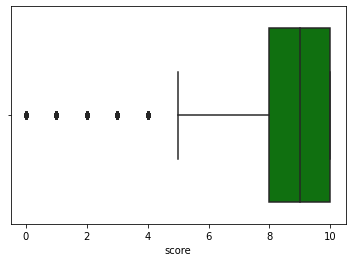

Boxplot of score
Q1 is :  8.0
Q2 is :  9.0
Q3 is :  10.0
IQR is: 2.0
Lower Whisker, Upper Whisker :  5.0 , 13.0
number of outliers are: 147411


In [98]:
# only score is the column which is numeric so we check it for outliers.
sns.boxplot(x= d_df['score'], color='green')
plt.show()
print('Boxplot of score')

Q1 = d_df['score'].quantile(0.25)
Q2 = d_df['score'].quantile(0.50)
Q3 = d_df['score'].quantile(0.75) 
IQR = Q3 - Q1
L_W = (Q1 - 1.5 *IQR)
U_W = (Q3 + 1.5 *IQR)    
print('Q1 is : ',Q1)
print('Q2 is : ',Q2)
print('Q3 is : ',Q3)
print('IQR is:',IQR)

print('Lower Whisker, Upper Whisker : ',L_W,',',U_W)
bools = (d_df['score'] < (Q1 - 1.5 *IQR)) |(d_df['score'] > (Q3 + 1.5 * IQR))
print('number of outliers are:',bools.sum()) 

In [100]:
# we'll now be removing outliers by removing data of outliers 
Q1 = d_df['score'].quantile(0.25)
Q3 = d_df['score'].quantile(0.75)
IQR = Q3 - Q1
d_df = d_df[(d_df['score'] > (Q1 - 1.5 *IQR)) & (d_df['score'] < (Q3 + 1.5 *IQR))]
bools = (d_df['score'] < (Q1 - 1.5 *IQR)) |(d_df['score'] > (Q3 + 1.5 * IQR))
print('number of outliers remaining:',bools.sum())   
d_df.shape

number of outliers remaining: 0


(849303, 3)

In [101]:
# now, we have cross validation tasks to perform:
cross_validate(algo,data_U, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([2.59821254, 2.63833819, 2.51304793]),
 'fit_time': (0.45838069915771484, 0.5007920265197754, 0.3130369186401367),
 'test_time': (0.014794111251831055,
  0.011487960815429688,
  0.01505732536315918)}

### OBSERVATION and INFERENCES from above:
- Most popular item is SAMSUNG GALAXY Note5.
- Most reviewed user is the Amazon customer.
- Most active is also Amazon customer.
- Lenovo K4 note was most rated/reviewed item.

### In what business scenario you should use popularity based Recommendation Systems ?
- Popularity based recommendation system relies on the popularity,trends and frequency counts of the item.
- The best scenario where this approch can be used is with a new user, for whom much information is not present and hence the latest and most popular options can be recommended.
- Travel Companies, during holiday seasons.
- Hotel Booking
- News applications
- New user in Netflix, amazon, youtube

### In what business scenario you should use CF based Recommendation Systems ?
- Collaborative Filtering is used recommender systems that can learn to give better recommendations as more information about users is collected.
- Shopping websites like Amazon, Flipkart will use this CF RS to analyse the user behaviour/pattern and recommend items.
- Food delivery apps like Swiggy and Zomato show popup notifications based on the CF recommendations for particular users.
- Spotify, the great music app understand user prefernecs and then recommend songs. That is also CF RS

### What other possible methods can you think of which can further improve the recommendation for different users ?
- Hybrind Models (combination of various existing models) could be of great use. Linking Popularity based with CF will be more impactful and helpful to the existing users.
- RS with respect to the demographic location, with the logic that people belonging to same place have same taste couls also be of great help.
- One powerful RS can be built by grouping/identifying the users of same family, csame corporate sector or company. One person who bought something, could be used company wide and hence could be a great recommended item for other employee of same company.
- Recommendation by Profession would also be of great impact and use.

Thanks,
Abhinandan